# All code needed to reproduce visualizations in the initial (prergistration) report

Note that throughout this report, we use the following appreviations:
- **Meta-ROI**: A larger region-of-interest (ROI) comprising multiple regions from the *Destrieux* atlas corresponding to hypothesized regions of visual perception and consciouss processing
- **GNWT**: Global neuronal workspace theory
- **IIT**: Integrated information theory
- **CS**: Category-selective

First, load the required libraries in python and R (laoded via the `rpy2`) module:

In [1]:
import os
import numpy as np
import pandas as pd
import sys
import json
import networkx as nx
import matplotlib.pyplot as plt
from venny4py.venny4py import *
import math

# Add rpy2
%load_ext rpy2.ipython

In [2]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(ComplexHeatmap)
    library(cowplot)
    library(facefuns)
    library(factoextra)
    library(FactoMineR)
    library(ggh4x)
    library(ggraph)
    library(ggpubr)
    library(ggrain)
    library(ggridges)
    library(ggseg)
    library(ggsegDesterieux)
    library(ggsignif)
    library(glue)
    library(igraph)
    library(LaCroixColoR)
    library(patchwork)
    library(RColorBrewer)
    library(rlist)
    library(scales)
    library(see)
    library(splitstackshape)
    library(tidyverse)
    library(VennDiagram) 
})


# Set cowplot theme
theme_set(theme_cowplot())

In addition: Warning message:
package ‘broom’ was built under R version 4.3.3 


## What is the spatial layout of the three meta-ROIs in the brain?

It is good to first visualize where -- and how much space -- each meta-ROI occupies in the cortex:

In [3]:
# Read in meta-ROI data from .json
with open("hypothesis_driven_ROIs.json") as f:
    meta_ROI_dict = json.load(f)

# Prepare a list of tuples corresponding to each meta-ROI
rows = []
for key, values in meta_ROI_dict.items():
    for value in values:
        rows.append((key, value))

# Convert the list of tuples to a dataframe that maps the meta-ROI to its constituent regions
meta_ROI_df = (pd.DataFrame(rows, columns=['meta_ROI', 'region'])
               .assign(region = lambda x: x.region.str.replace("_", " ")))

pyspi_SPI_info = pd.read_csv("feature_extraction/pyspi_SPI_info.csv")

merging atlas and data by 'region'


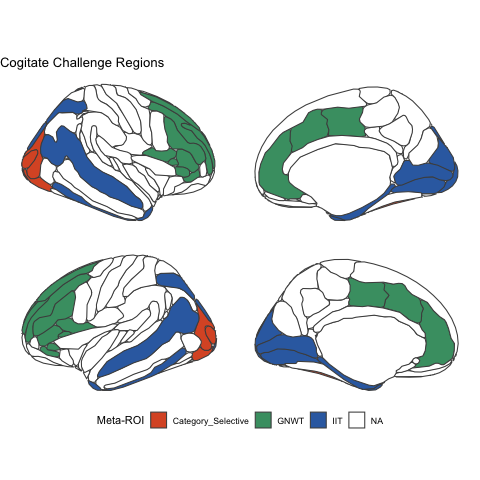

In [4]:
%%R -i meta_ROI_df

# Prepare the meta ROI lookup table dataframe for plotting with ggseg
meta_ROI_df_to_plot <- meta_ROI_df %>% 
  rowwise() %>%
  mutate(meta_ROI = str_split(meta_ROI, "_ROIs")[[1]][1])

# Call ggseg using the desterieux [sic] atlas, mapping the fill color to the meta-ROI
ggseg(atlas = desterieux, 
      mapping = aes(fill = meta_ROI), .data=meta_ROI_df_to_plot,
      color = "gray30", position = "stacked") +
  theme_void() +
  labs(title="Cogitate Challenge Regions", fill="Meta-ROI") +
  scale_fill_manual(values = c("Category_Selective" = "#DB582D",
                               "GNWT" = "#479D72",
                               "IIT" = "#346DB0"),
                    na.value = 'white') +
  theme(legend.position = "bottom")
# ggsave('plots/Cogitate_Meta_ROIs.svg', width=5, height=3, units='in', dpi=300)

## How does each SPI perform in distinguishing (1) stimulus type and (2) relevance type, using averaged epochs compared across participants?

We can load the results from the logistic regression classification for (1) stimulus type and (2) relevance type):

In [5]:
# Load pyspi results -- update to where you have stored your pyspi results
pyspi_res_path = "/Users/abry4213/data/Cogitate_Batch1/MEG_Data/derivatives/time_series_features/averaged_epochs"

# Load classification res -- update to where you have stored your classification results
classification_res_path = "/Users/abry4213/data/Cogitate_Batch1/MEG_Data/derivatives/classification_results/across_participants"
stimulus_type_classification_res = pd.read_csv(f"{classification_res_path}/comparing_between_stimulus_types_classification_results.csv")
relevance_type_classification_res = pd.read_csv(f"{classification_res_path}/comparing_between_relevance_types_classification_results.csv")

# Add meta_ROI_pair column that combines the 'from' and 'to' meta-ROIs
stimulus_type_classification_res["meta_ROI_pair"] = stimulus_type_classification_res.meta_ROI_from + "_" + stimulus_type_classification_res.meta_ROI_to
relevance_type_classification_res["meta_ROI_pair"] = relevance_type_classification_res.meta_ROI_from + "_" + relevance_type_classification_res.meta_ROI_to

# Rename stimulus to stimulus_presentation if it's present
if "stimulus" in stimulus_type_classification_res.columns:
    if "stimulus_presentation" not in stimulus_type_classification_res.columns:
        stimulus_type_classification_res.rename(columns={"stimulus": "stimulus_presentation"}, inplace=True)
    else:
        stimulus_type_classification_res.drop(columns=["stimulus"], inplace=True)
if "stimulus" in relevance_type_classification_res.columns:
    if "stimulus_presentation" not in relevance_type_classification_res.columns:
        relevance_type_classification_res.rename(columns={"stimulus": "stimulus_presentation"}, inplace=True)
    else:
        relevance_type_classification_res.drop(columns=["stimulus"], inplace=True)

# Load in pyspi results
all_pyspi_res_list = []
for pyspi_res_file in os.listdir(pyspi_res_path):
    pyspi_res = pd.read_csv(f"{pyspi_res_path}/{pyspi_res_file}").assign(relevance_type = lambda x: x.relevance_type.str.replace(" ", "-"))

    # Rename stimulus to stimulus_presentation if it's present
    if "stimulus" in pyspi_res.columns:
        if "stimulus_presentation" not in pyspi_res.columns:
            pyspi_res.rename(columns={"stimulus": "stimulus_presentation"}, inplace=True)
        else:
            pyspi_res.drop(columns=["stimulus"], inplace=True)
    
    all_pyspi_res_list.append(pyspi_res)

all_pyspi_res = pd.concat(all_pyspi_res_list)

## What is the overall distribution in SPI performance per classification task?

Before diving into any specific result, let's first see the distribution in performance across all SPIs per stimulus task classification problem (e.g., 'Face' vs. 'Object') by meta-ROI pair (e.g., 'GNWT' to 'CS')

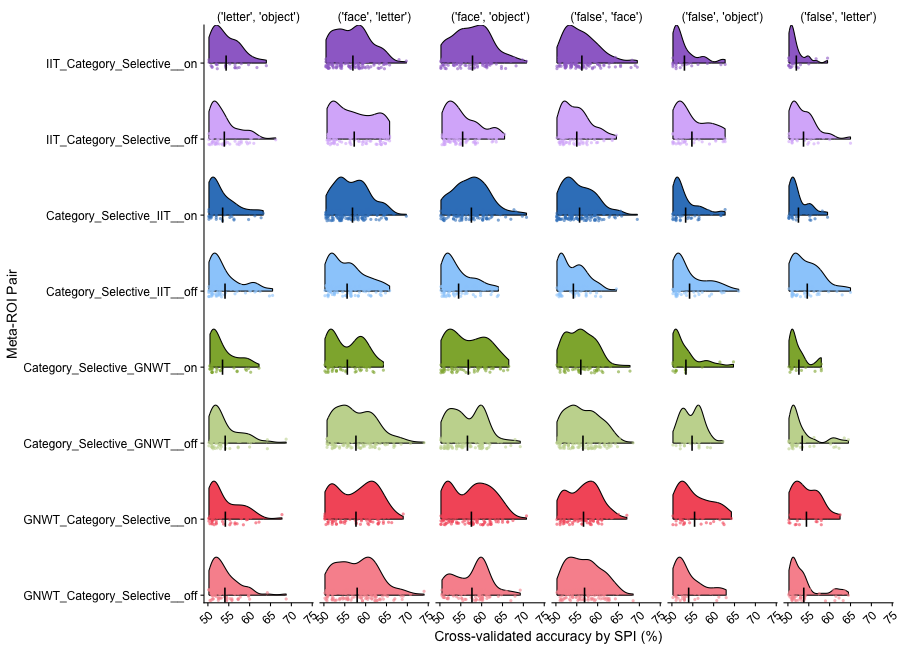

In [6]:
%%R -i stimulus_type_classification_res -w 900 -h 650 

# Create raincloud plot visualization for all stimulus type classification results
stimulus_type_classification_res %>% 
    # Filter accuracy to >50% for visualization purposes
    filter(accuracy > 0.5) %>%
    mutate(accuracy = 100*accuracy, 
           stimulus_presentation = factor(stimulus_presentation, levels = c("on", "off"))) %>%
    rowwise() %>%
    # Want a specific order for the meta-ROI pair and stimulus presentation period in the plot
    mutate(sp_and_roi = paste0(meta_ROI_pair, "__", stimulus_presentation)) %>%
    mutate(sp_and_roi = factor(sp_and_roi, levels = rev(c("IIT_Category_Selective__on",
                                                        "IIT_Category_Selective__off",
                                                        "Category_Selective_IIT__on",
                                                        "Category_Selective_IIT__off",
                                                        "Category_Selective_GNWT__on",
                                                        "Category_Selective_GNWT__off",
                                                        "GNWT_Category_Selective__on",
                                                        "GNWT_Category_Selective__off"))),
                stimulus_combo = fct_reorder(stimulus_combo, accuracy, .fun=mean)) %>%
    ggplot(data=., mapping=aes(x=sp_and_roi, y=accuracy, fill=sp_and_roi)) +
    # Create half violins colored by meta-ROI pair and stimulus presentation period
    geom_violinhalf(scale="width", color="black", position = position_dodge(width = 1), width=1)  +
    geom_point(aes(color = sp_and_roi), position = position_jitter(width = 0.075, height=0),
                            size = 1.5, alpha=0.6, stroke=0) +
    stat_summary(color="black", fun="mean", geom="crossbar", width=0.2, linewidth=0.3, 
            show.legend=FALSE, position = position_dodge(width=1.4)) +
    # Custom color lookup table for (1) meta-ROI pair and (2) stimulus presentation period
    scale_color_manual(values=c("IIT_Category_Selective__on" = "#9F70CE",
                                "IIT_Category_Selective__off" = "#D9B7FA",
                                "Category_Selective_IIT__on" = "#3982C4",
                                "Category_Selective_IIT__off" = "#9BCEFB",
                                "Category_Selective_GNWT__on" = "#8EB03A",
                                "Category_Selective_GNWT__off" = "#C6D79D",
                                "GNWT_Category_Selective__on" = "#f55c69",
                                "GNWT_Category_Selective__off" = "#f8949c")) +
    scale_fill_manual(values=c("IIT_Category_Selective__on" = "#9F70CE",
                                "IIT_Category_Selective__off" = "#D9B7FA",
                                "Category_Selective_IIT__on" = "#3982C4",
                                "Category_Selective_IIT__off" = "#9BCEFB",
                                "Category_Selective_GNWT__on" = "#8EB03A",
                                "Category_Selective_GNWT__off" = "#C6D79D",
                                "GNWT_Category_Selective__on" = "#f55c69",
                                "GNWT_Category_Selective__off" = "#f8949c")) +
    facet_grid(. ~ stimulus_combo, scales="free") + 
    theme(legend.position = "bottom") +
    scale_x_discrete(expand = c(0, 0))+
    xlab("Meta-ROI Pair") +
    ylab("Cross-validated accuracy by SPI (%)") +
    labs(fill="Stimulus Presentation", color="Stimulus Presentation") +
    theme(strip.background = element_blank(),
          legend.position="none",
          axis.text.x = element_text(angle=45, hjust=1)) +
    coord_flip()

# ggsave('plots/Stimulus_wise_classification_performance_by_meta_ROI_pair.svg', width=10, height=6, units='in', dpi=300)

## Overview visualization of relevance type classification 

As with stimulus type above, we can also look at the overall distribution in SPI-wise performance at distinguishing between 'Relevant non-target' versus 'Irrelevant' event-related fields (ERFs):

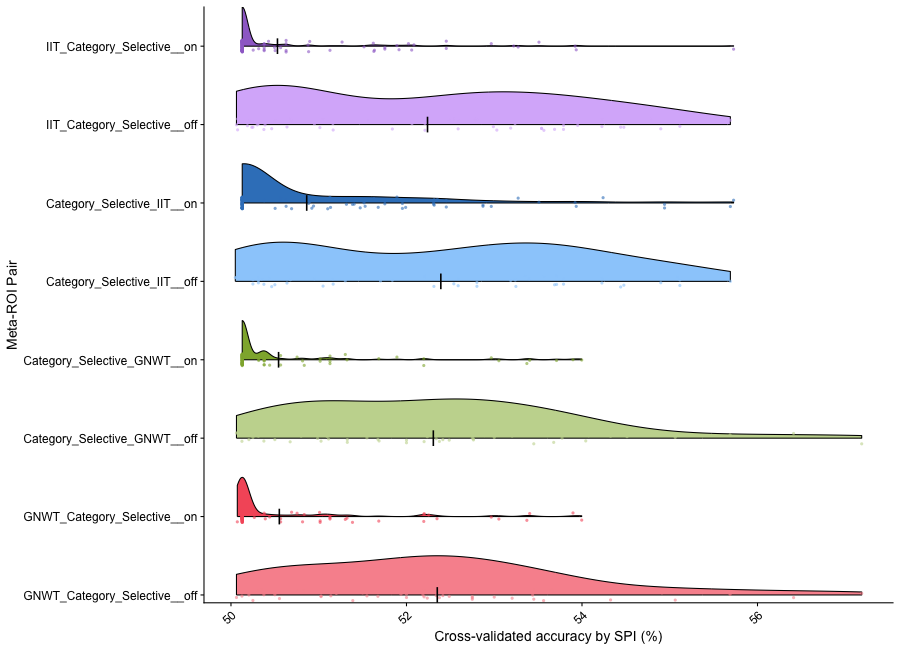

In [7]:
%%R -i relevance_type_classification_res -w 900 -h 650 

# Create raincloud plot visualization for all stimulus type classification results
relevance_type_classification_res %>% 
    # Filter accuracy to >50% for visualization purposes
    filter(accuracy > 0.5) %>%
    mutate(accuracy = 100*accuracy, 
           stimulus_presentation = factor(stimulus_presentation, levels = c("on", "off"))) %>%
    rowwise() %>%
    mutate(sp_and_roi = paste0(meta_ROI_pair, "__", stimulus_presentation)) %>%
    mutate(sp_and_roi = factor(sp_and_roi, levels = rev(c("IIT_Category_Selective__on",
                                                        "IIT_Category_Selective__off",
                                                        "Category_Selective_IIT__on",
                                                        "Category_Selective_IIT__off",
                                                        "Category_Selective_GNWT__on",
                                                        "Category_Selective_GNWT__off",
                                                        "GNWT_Category_Selective__on",
                                                        "GNWT_Category_Selective__off")))) %>%
    ggplot(data=., mapping=aes(x=sp_and_roi, y=accuracy, fill=sp_and_roi)) +
    # Create half violins colored by meta-ROI pair and stimulus presentation period
    geom_violinhalf(scale="width", color="black", position = position_dodge(width = 1), width=1)  +
    geom_point(aes(color = sp_and_roi), position = position_jitter(width = 0.075, height=0),
                            size = 1.5, alpha=0.6, stroke=0) +
    stat_summary(color="black", fun="mean", geom="crossbar", width=0.2, linewidth=0.3, 
            show.legend=FALSE, position = position_dodge(width=1.4)) +
    # Custom color lookup table for (1) meta-ROI pair and (2) stimulus presentation period
    scale_color_manual(values=c("IIT_Category_Selective__on" = "#9F70CE",
                                "IIT_Category_Selective__off" = "#D9B7FA",
                                "Category_Selective_IIT__on" = "#3982C4",
                                "Category_Selective_IIT__off" = "#9BCEFB",
                                "Category_Selective_GNWT__on" = "#8EB03A",
                                "Category_Selective_GNWT__off" = "#C6D79D",
                                "GNWT_Category_Selective__on" = "#f55c69",
                                "GNWT_Category_Selective__off" = "#f8949c")) +
    scale_fill_manual(values=c("IIT_Category_Selective__on" = "#9F70CE",
                                "IIT_Category_Selective__off" = "#D9B7FA",
                                "Category_Selective_IIT__on" = "#3982C4",
                                "Category_Selective_IIT__off" = "#9BCEFB",
                                "Category_Selective_GNWT__on" = "#8EB03A",
                                "Category_Selective_GNWT__off" = "#C6D79D",
                                "GNWT_Category_Selective__on" = "#f55c69",
                                "GNWT_Category_Selective__off" = "#f8949c")) +
    theme(legend.position = "bottom") +
    scale_x_discrete(expand = c(0, 0))+
    xlab("Meta-ROI Pair") +
    ylab("Cross-validated accuracy by SPI (%)") +
    labs(fill="Stimulus Presentation", color="Stimulus Presentation") +
    theme(strip.background = element_blank(),
          legend.position="none",
          axis.text.x = element_text(angle=45, hjust=1)) +
    coord_flip()

# ggsave('plots/Relevance_type_classification_performance_by_meta_ROI_pair.svg', width=4.5, height=6, units='in', dpi=300)

Across all four meta-ROI pairs, the maximum cross-validated classification accuracy with any SPI is 58%—and most are below 55%, indicating that the MEG signal was generally less distinguishable based on task relevance using the 199 evaluated SPIs. 
As such, for the rest of this report, we focus on the first classification aim (i.e., distinguishing between stimulus types).

## For each meta-ROI pair, what is the maximum accuracy across contexts?

Next, for each stimulus comparison and meta-ROI pair, we will examine the maximum cross-validated classification accuracy obtained with any SPI, relevance type, and stimulus presentation period.

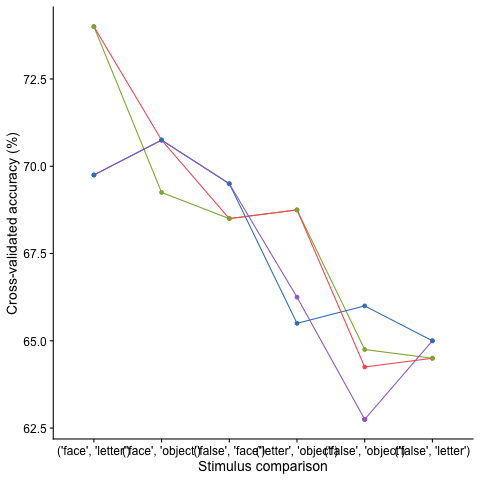

In [8]:
%%R -i stimulus_type_classification_res

# Line plot showing the maximum cross-validated accuracy for each 
# stimulus comparison (x-axis) and meta-ROI pair (colored lines)
stimulus_type_classification_res %>% 
    group_by(meta_ROI_pair, stimulus_combo) %>% 
    # Find maximum accuracy
    filter(accuracy==max(accuracy,na.rm=T)) %>%
    ungroup() %>%
    mutate(accuracy=100*accuracy, 
            stimulus_combo = fct_reorder(stimulus_combo, accuracy, .fun=max, .desc=TRUE)) %>%
    ggplot(data=., mapping=aes(x=stimulus_combo, y=accuracy, color=meta_ROI_pair, group=meta_ROI_pair)) +
    geom_line() +
    geom_point() + 
    xlab("Stimulus comparison") +
    theme(legend.position="none") +
    ylab("Cross-validated accuracy (%)") +
    scale_color_manual(values=c("IIT_Category_Selective" = "#9F70CE",
                                "Category_Selective_IIT" = "#3982C4",
                                "Category_Selective_GNWT" = "#8EB03A",
                                "GNWT_Category_Selective" = "#f55c69"))

# ggsave('plots/Max_performance_for_each_stim_combo_by_meta_ROI_pair.svg', width=5.5, height=3.25, units='in', dpi=300)

## What does the distribution of each stimulus type look like for the top SPI per meta-ROI pair?

If we zoom in on the 'Face' vs. 'Letter' comparison, what do the actual feature values look like in the average Face vs. Object ERF per participant?

/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


Adding missing grouping variables: `meta_ROI_pair`
Joining with `by = join_by(SPI, meta_ROI_from, meta_ROI_to, relevance_type,
stimulus_presentation)`


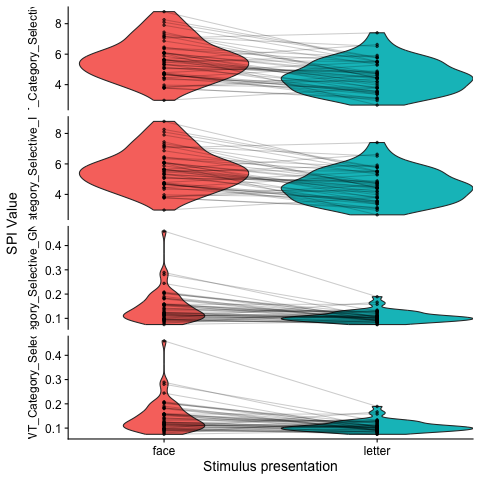

In [9]:
%%R -i stimulus_type_classification_res,all_pyspi_res -o pyspi_res_top_SPIs,top_SPI

top_SPI <- stimulus_type_classification_res %>%
    filter(stimulus_combo=="('face', 'letter')") %>% 
    ungroup() %>% 
    group_by(meta_ROI_pair) %>%
    filter(accuracy == max(accuracy)) %>% 
    dplyr::select(meta_ROI_to, meta_ROI_from, SPI, stimulus_presentation, relevance_type) 

pyspi_res_top_SPIs <- all_pyspi_res %>% 
    semi_join(., top_SPI) %>% 
    filter(stimulus_type %in% c("face", "letter"))

pyspi_res_top_SPIs %>% 
    mutate(meta_ROI_pair = glue("{meta_ROI_from}_{meta_ROI_to}")) %>%
    ungroup() %>%
    mutate(meta_ROI_pair = factor(meta_ROI_pair, levels = c("IIT_Category_Selective", 
                                                            "Category_Selective_IIT",
                                                            "Category_Selective_GNWT",
                                                            "GNWT_Category_Selective"))) %>% 
    ggplot(data=., mapping=aes(x=stimulus_type, y=value)) +
    geom_violin(aes(fill=stimulus_type)) + 
    geom_point(aes(group=subject_ID), alpha=0.6, size=0.85) +
    geom_line(aes(group=subject_ID), alpha=0.2, linewidth=0.5) +
    xlab("Stimulus presentation") +
    ylab("SPI Value") +
    facet_grid(meta_ROI_pair ~ ., scales="free", switch="both") +
    scale_x_discrete(expand=c(0,0)) +
    theme(strip.placement="outside", 
            strip.background=element_blank(),
            legend.position="none")

# ggsave('plots/Face_vs_Letter_top_SPI_by_region_pair.svg', width=3, height=4.5, units='in', dpi=300)

## What if we take the SPIs with accuracy > 65% and compare across A) ROI pairs and B) stimulus types?

We are interested in the overlap in the highest-performing SPIs per context, first comparing between meta-ROI pairs and subsequently between stimulus types.

For meta-ROI pairs (4), we can visualize this with an adapted Venn Diagram:

In [10]:
%%R -i stimulus_type_classification_res -o SPIs_greater_than_65_by_meta_ROI_pair,IIT_Category_Selective_list,Category_Selective_IIT_list,Category_Selective_GNWT_list,GNWT_Category_Selective_list

# First, compare across ROI pairs
SPIs_greater_than_65_by_meta_ROI_pair <- stimulus_type_classification_res %>% 
    mutate(accuracy = 100*accuracy) %>%
    dplyr::select(meta_ROI_pair, SPI, accuracy) %>%
    group_by(meta_ROI_pair, SPI) %>% 
    filter(accuracy == max(accuracy)) %>% 
    rowwise() %>%
    filter(accuracy > 65) %>% 
    distinct() %>%
    mutate(meta_ROI_pair = factor(meta_ROI_pair, levels = c("IIT_Category_Selective", 
                                                                "Category_Selective_IIT",
                                                                "Category_Selective_GNWT",
                                                                "GNWT_Category_Selective")))

SPIs_greater_than_65_by_meta_ROI_pair_split <- split(SPIs_greater_than_65_by_meta_ROI_pair$SPI, SPIs_greater_than_65_by_meta_ROI_pair$meta_ROI_pair)
IIT_Category_Selective_list <- SPIs_greater_than_65_by_meta_ROI_pair_split[[1]]
Category_Selective_IIT_list <- SPIs_greater_than_65_by_meta_ROI_pair_split[[2]]
Category_Selective_GNWT_list <- SPIs_greater_than_65_by_meta_ROI_pair_split[[3]]
GNWT_Category_Selective_list <- SPIs_greater_than_65_by_meta_ROI_pair_split[[4]]

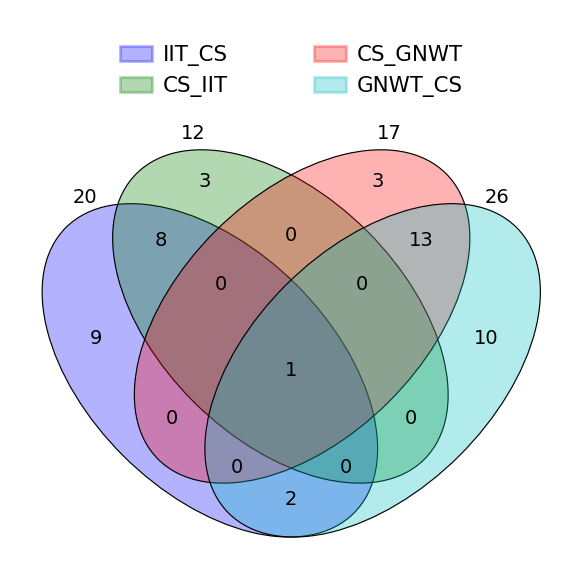

In [11]:
# Venn diagram for meta-ROI pairs
my_sets = {
    'IIT_CS': set(IIT_Category_Selective_list),
        'CS_IIT': set(Category_Selective_IIT_list),
        'CS_GNWT': set(Category_Selective_GNWT_list),
        'GNWT_CS': set(GNWT_Category_Selective_list)
}

venny4py(sets = my_sets, out="plots/", ext="svg", dpi=300)

## What type(s) of SPIs perform the best (1) by meta-ROI pair and (2) by stimulus type comparison?

Since each SPI belongs to a particular literature category (e.g., 'spectral' or 'information theory'), we can compare the composition of the top-performing (>65% accuracy) SPIs in each context -- first, by meta-ROI pair:

Joining with `by = join_by(SPI)`


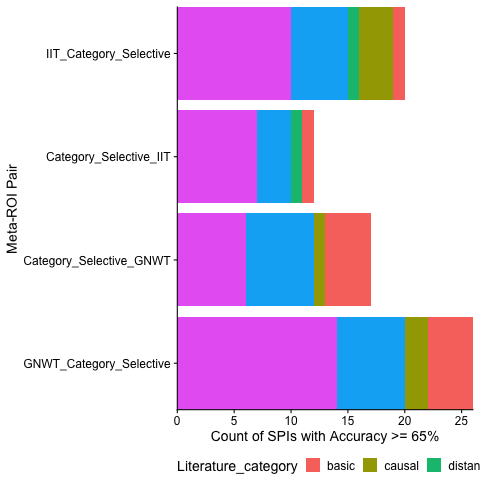

In [12]:
%%R -i SPIs_greater_than_65_by_meta_ROI_pair,pyspi_SPI_info 

# A) By meta-ROI pair, stacked bar chart showing the relative composition of SPIs with accuracy > 65%
SPIs_greater_than_65_by_meta_ROI_pair %>% 
    left_join(., pyspi_SPI_info) %>% 
        mutate(meta_ROI_pair = factor(meta_ROI_pair, levels = rev(c("IIT_Category_Selective", 
                                                                "Category_Selective_IIT",
                                                                "Category_Selective_GNWT",
                                                                "GNWT_Category_Selective")))) %>%
    ggplot(data=., mapping=aes(x=meta_ROI_pair, fill=Literature_category)) +
    geom_bar() +
    coord_flip() +
    xlab("Meta-ROI Pair") +
    scale_y_continuous(expand=c(0,0)) +
    scale_x_discrete(expand=c(0,0)) +
    ylab("Count of SPIs with Accuracy >= 65%") +
    theme(legend.position = "bottom")

# ggsave('plots/Meta_ROI_pair_top_SPI_categories.svg', width=6, height=3.5, units='in', dpi=300)

Then, by stimulus combination pair:

Joining with `by = join_by(SPI)`


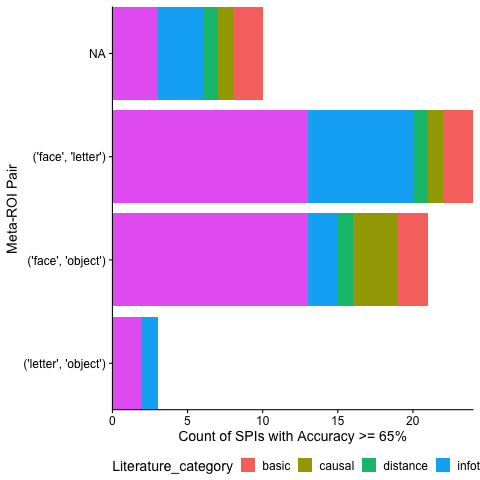

In [13]:
%%R -i stimulus_type_classification_res,pyspi_SPI_info -o SPIs_greater_than_65_by_stimulus_combo

# First, compute the SPIs that do better than 65% accuracy by stimulus combo
SPIs_greater_than_65_by_stimulus_combo <- stimulus_type_classification_res %>% 
    mutate(accuracy = 100*accuracy) %>%
    dplyr::select(stimulus_combo, SPI, accuracy) %>%
    group_by(stimulus_combo, SPI) %>% 
    filter(accuracy == max(accuracy)) %>% 
    rowwise() %>%
    filter(accuracy > 65) %>% 
    distinct() %>% 
    mutate(stimulus_combo = factor(stimulus_combo, levels = rev(c( "('face', 'letter')", "('face', 'object')",  
                                                             "('False', 'face')",  "('False', 'letter')",
                                                              "('letter', 'object')", "('False', 'object')"))))

# Create stacked bar chart showing the relative composition of SPIs with accuracy > 65%
SPIs_greater_than_65_by_stimulus_combo %>% 
    left_join(., pyspi_SPI_info) %>%
    ggplot(data=., mapping=aes(x=stimulus_combo, fill=Literature_category)) +
    geom_bar() +
    coord_flip() +
    xlab("Meta-ROI Pair") +
    scale_y_continuous(expand=c(0,0)) +
    scale_x_discrete(expand=c(0,0)) +
    ylab("Count of SPIs with Accuracy >= 65%") +
    theme(legend.position = "bottom")

# ggsave('plots/Stimulus_combo_top_SPI_categories.svg', width=6, height=3.5, units='in', dpi=300)